In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!unzip /content/gdrive/MyDrive/Kaggle/Pog_Music_Classification/data/mel_spec_aug/mel_spec_train_aug.zip > /dev/null

In [3]:
!pip install -q pytorch_lightning

     |████████████████████████████████| 582 kB 8.3 MB/s 
     |████████████████████████████████| 596 kB 55.8 MB/s 
     |████████████████████████████████| 136 kB 73.2 MB/s 
     |████████████████████████████████| 408 kB 74.1 MB/s 
     |████████████████████████████████| 1.1 MB 51.5 MB/s 
     |████████████████████████████████| 94 kB 4.0 MB/s 
     |████████████████████████████████| 144 kB 76.4 MB/s 
     |████████████████████████████████| 271 kB 71.0 MB/s 


In [4]:
!pip install -q albumentations==0.4.6

     |████████████████████████████████| 117 kB 7.1 MB/s 
     |████████████████████████████████| 948 kB 44.4 MB/s 


In [5]:
!pip uninstall -y opencv-python-headless==4.5.5.62

In [6]:
!pip install -q opencv-python-headless==4.5.2.52

     |████████████████████████████████| 38.2 MB 1.2 MB/s 


In [7]:
!pip install -q timm

     |████████████████████████████████| 431 kB 5.0 MB/s 


In [8]:
!pip install -q optuna

     |████████████████████████████████| 308 kB 9.1 MB/s 
     |████████████████████████████████| 81 kB 11.9 MB/s 
     |████████████████████████████████| 210 kB 28.9 MB/s 
     |████████████████████████████████| 78 kB 8.8 MB/s 
     |████████████████████████████████| 49 kB 7.4 MB/s 
     |████████████████████████████████| 113 kB 57.3 MB/s 
     |████████████████████████████████| 146 kB 75.2 MB/s 


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import os
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader
from sklearn import model_selection
from PIL import Image
import albumentations as alb
import torch.multiprocessing as mp
import warnings

warnings.filterwarnings('ignore')

In [10]:
class Models:
    RESNET34 = "resnet34"
    RESNET50 = "resnet50"
    RESNEXT50 = "resnext50_32x4d"
    EFFNET_B4 = "tf_efficientnet_b4_ns"

class ImgStats:
    IMAGENET_MEAN = [0.485, 0.456, 0.406]
    IMAGENET_STD = [0.229, 0.224, 0.225]    

# CONSTANTS
class Config:
    # whether to use mel spectrograms generated using audio augmentations ( multiple mel spec for one audio)
    USE_MEL_SPEC_AUG = True
    RUNTIME = "COLAB"    
    NUM_CLASSES = 19
    BATCH_SIZE = 256
    NUM_FOLDS = 5    
    NUM_EPOCHS = 2
    INPUT_IMAGE_SIZE = (128,128)
    IMG_MEAN = ImgStats.IMAGENET_MEAN
    IMG_STD = ImgStats.IMAGENET_STD
    NUM_WORKERS = mp.cpu_count()        
    RANDOM_SEED = 42
    MODEL_TO_USE = Models.EFFNET_B4
    PRETRAINED = False            
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    MODEL_PATH = "/content/gdrive/MyDrive/Kaggle/Pog_Music_Classification/data/model/EFFNET_B4/fold0_effnet_b4_best_model_epoch=9_val_loss=1.5308.ckpt"
    # model hyperparameters
    MODEL_PARAMS = {    
        "drop_out": 0.25,
        "lr": 1e-4
    }

In [11]:
if Config.RUNTIME == "COLAB":
    Config.DATA_ROOT_FOLDER = "/content/gdrive/MyDrive/Kaggle/Pog_Music_Classification/data/"
    Config.IMG_ROOT_FOLDER = "/content/processed_train_aug/mel_spec/"
elif Config.RUNTIME == "KAGGLE":
    Config.DATA_ROOT_FOLDER = "../input/pog-musicclf-melspec-aug/"
    Config.IMG_ROOT_FOLDER = "/kaggle/input/pog-musicclf-melspec-aug/mel_spec_test_aug/processed_test_aug/mel_spec/"        
else:
    Config.DATA_ROOT_FOLDER = "./data/"
    Config.IMG_ROOT_FOLDER = "./data/processed_train/mel_spec/"

In [12]:
# split the training dataframe into kfolds for cross validation. We do this before any processing is done
# on the data. We use stratified group kfold if the target distribution is unbalanced and multiple records belong to
# a single group (song_id). To prevent data leakage we need to ensure all records of a group are assigned to one fold only
# i.e. there is no leakage between train and validation sets
def strat_group_kfold_dataframe(df, target_col_name, num_folds=Config.NUM_FOLDS):
    # we create a new column called kfold and fill it with -1
    df["kfold"] = -1
    # randomize of shuffle the rows of dataframe before splitting is done
    df = df.sample(frac=1, random_state=Config.RANDOM_SEED).reset_index(drop=True)
    # get the target data
    y = df[target_col_name].values
    groups = df.song_id.values
    skf = model_selection.StratifiedGroupKFold(n_splits=num_folds, shuffle=True, random_state=Config.RANDOM_SEED)
    for fold, (train_index, val_index) in enumerate(skf.split(X=df, y=y, groups=groups)):
        df.loc[val_index, "kfold"] = fold    
    return df     

if Config.USE_MEL_SPEC_AUG:
    df_train = pd.read_csv(Config.DATA_ROOT_FOLDER + "mel_spec_aug/df_train_aug.csv")
else:
    df_train = pd.read_csv(Config.DATA_ROOT_FOLDER + "train.csv")
    # filter out records without any corresponding mel spectrogram image
    df_train["mspec_exists"] = df_train.filename.map(
        lambda fp: os.path.exists(Config.IMG_ROOT_FOLDER + fp.split(".")[0] + ".jpg")
    )
    df_train = df_train[df_train.mspec_exists]
df_train = strat_group_kfold_dataframe(df_train, target_col_name="genre_id")
df_train.head()

,Unnamed: 0,song_id,filename,filepath,genre_id,genre,file_exists,mel_spec,kfold
0,1318,17566,017566.ogg,train/017566.ogg,0,Electronic,True,017566_3.jpg,1
1,41188,5108,005108.ogg,train/005108.ogg,1,Rock,True,005108_1.jpg,2
2,10154,13172,013172.ogg,train/013172.ogg,8,Pop,True,013172_3.jpg,4
3,69851,13412,013412.ogg,train/013412.ogg,3,Experimental,True,013412_3.jpg,4
4,13325,5051,005051.ogg,train/005051.ogg,1,Rock,True,005051_4.jpg,1


In [13]:
df_train_0 = df_train[df_train.kfold == 0]
df_train_0.genre_id.value_counts()

1     3080
0     2970
2     2490
4     1875
3     1790
5     1305
6     1265
8      975
7      925
9      875
10     705
12     435
11     435
13     345
14     180
15     110
16      85
17      50
18      15
Name: genre_id, dtype: int64

In [14]:
# A dataset contains the logic to fetch, load and if required transform data to bring it to a format
# that can be used by dataloaders for training. Image size is (128, 385, 3)
class AudioMelSpecImgDataset(Dataset):
    def __init__(self, df, file_name_col, target_col, img_root_folder, transform=None, target_transform=None):
        self.df = df
        self.file_name_col = file_name_col
        self.target_col = target_col
        self.img_root_folder = img_root_folder
        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, index):
        if Config.USE_MEL_SPEC_AUG:
            mel_spec_img = self.df.loc[index, self.file_name_col]
            img_path = self.img_root_folder + mel_spec_img
        else:            
            file_name_noext = self.df.loc[index, self.file_name_col].split(".")[0]        
            img_path = self.img_root_folder + "/" + file_name_noext + ".jpg"        
        img = Image.open(img_path)
        img_arr = np.array(img)
        img_label = self.df.loc[index, self.target_col]
        if self.transform is not None:
            augmented = self.transform(image=img_arr)
            img_tfmd = augmented["image"]
            #img_tfmd = self.transform(img)            
        if self.target_transform is not None:
            img_label = self.target_transform(img_label)
        #song_id = self.df.loc[index, "song_id"] 
        return index, img_tfmd, img_label

    def __len__(self):
        return len(self.df)

In [15]:
from albumentations.pytorch import ToTensorV2

train_transform = alb.Compose([
        alb.RandomResizedCrop(Config.INPUT_IMAGE_SIZE[0], Config.INPUT_IMAGE_SIZE[1]),        
        alb.HorizontalFlip(p=0.5),
        alb.VerticalFlip(p=0.5),
        alb.augmentations.transforms.JpegCompression(p=0.5),
        alb.augmentations.transforms.ImageCompression(
            p=0.5, 
            compression_type=alb.augmentations.transforms.ImageCompression.ImageCompressionType.WEBP
        ),
        alb.Normalize(mean=Config.IMG_MEAN, std=Config.IMG_STD),
        ToTensorV2()
])

val_transform = alb.Compose([
        alb.CenterCrop(Config.INPUT_IMAGE_SIZE[0], Config.INPUT_IMAGE_SIZE[1]),
        alb.Normalize(mean=Config.IMG_MEAN, std=Config.IMG_STD),
        ToTensorV2()        
])

In [16]:
def get_fold_dls(fold, df_imgs, img_root_folder):
    df_train = df_imgs[df_imgs["kfold"] != fold].reset_index(drop=True)
    df_val = df_imgs[df_imgs["kfold"] == fold].reset_index(drop=True)    
    ds_train = AudioMelSpecImgDataset(
        df_train, 
        file_name_col="mel_spec",
        target_col="genre_id",
        img_root_folder=img_root_folder,
        transform=train_transform,
        target_transform=torch.as_tensor
    )
    ds_val = AudioMelSpecImgDataset(
        df_val, 
        file_name_col="mel_spec",
        target_col="genre_id",
        img_root_folder=img_root_folder,
        transform=val_transform,
        target_transform=torch.as_tensor
    )        
    dl_train = DataLoader(ds_train, batch_size=Config.BATCH_SIZE, shuffle=True, num_workers=Config.NUM_WORKERS)    
    dl_val = DataLoader(ds_val, batch_size=Config.BATCH_SIZE, num_workers=Config.NUM_WORKERS)
    return dl_train, dl_val, ds_train, ds_val

In [17]:
# display images along with their labels from a batch where images are in form of numpy arrays 
# if predictions are provided along with labels, these are displayed too
def show_batch(img_ds, num_items, num_rows, num_cols, predict_arr=None):
    fig = plt.figure(figsize=(12, 6))    
    img_index = np.random.randint(0, len(img_ds)-1, num_items)
    for index, img_index in enumerate(img_index):  # list first 9 images
        id, img, lb = img_ds[img_index]        
        ax = fig.add_subplot(num_rows, num_cols, index + 1, xticks=[], yticks=[])
        if isinstance(img, torch.Tensor):
            img = img.detach().numpy()
        if isinstance(img, np.ndarray):
            # the image data has RGB channels at dim 0, the shape of 3, 64, 64 needs to be 64, 64, 3 for display            
            img = img.transpose(1, 2, 0)
            ax.imshow(img)        
        if isinstance(lb, torch.Tensor):
            # extract the label from label tensor
            lb = lb.item()            
        title = f"Actual: {lb}"
        if predict_arr: 
            title += f", Pred: {predict_arr[img_index]}"        
        ax.set_title(title)  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


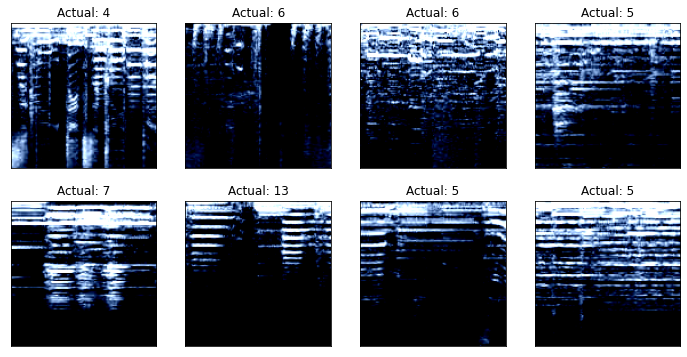

In [18]:
dl_train, dl_val, ds_train, ds_val = get_fold_dls(0, df_train, Config.IMG_ROOT_FOLDER)
show_batch(ds_val, 8, 2, 4)

In [19]:
import torch.nn as nn
import timm

class MusicClfLitModel(pl.LightningModule):
    def __init__(self, num_classes, hparams, model_to_use):
        super().__init__()
        self.save_hyperparameters()
        self.lr = hparams["lr"]
        self.num_classes = num_classes              
        self.backbone, self.classifier = self.get_backbone_classifier(model_to_use, hparams["drop_out"], num_classes) 

    @staticmethod
    def get_backbone_classifier(model_to_use, drop_out, num_classes):
        pt_model = timm.create_model(model_to_use, pretrained=Config.PRETRAINED)
        backbone = None
        classifier = None
        if model_to_use in [Models.RESNET34, Models.RESNET50, Models.RESNEXT50]:            
            backbone = nn.Sequential(*list(pt_model.children())[:-1])
            in_features = pt_model.fc.in_features
            classifier = nn.Sequential(
                nn.Dropout(drop_out),
                nn.Linear(in_features, num_classes)
            )
        if model_to_use in [Models.EFFNET_B4]:
            backbone = nn.Sequential(*list(pt_model.children())[:-1])
            in_features = pt_model.classifier.in_features
            classifier = nn.Linear(in_features, num_classes)
                    
        return backbone, classifier

    def forward(self, x):
        features = self.backbone(x)
        features = torch.flatten(features, 1)                
        x = self.classifier(features)
        soft_max = nn.Softmax(dim=1)        
        proba = soft_max(x)
        return proba        

In [20]:
from tqdm.notebook import tqdm

# For a specific fold get the predictions on oof (validation) data. We do this for each fold
# We then use these oof predictions to calculate the cross validation score (using the evaluation metric)
def get_oof_preds(fold, dl_val):
    # get the best model (having lowest val loss) for the fold
    best_model_path_val_loss = Config.MODEL_PATH
    print(f"Using best model = {best_model_path_val_loss} for oof prediction on fold {fold} validation set")
    best_model = MusicClfLitModel.load_from_checkpoint(
        checkpoint_path=best_model_path_val_loss,
        num_classes=Config.NUM_CLASSES, 
        hparams=Config.MODEL_PARAMS,        
        model_to_use=Config.MODEL_TO_USE
    )
    best_model.to(Config.DEVICE)
    if "val_preds" not in df_train.columns:
        df_train["val_preds"] = len(df_train) * [-100]
    val_preds_fold = []
    val_gt_fold = []        
    with torch.no_grad():        
        for id, X, y in tqdm(dl_val):
            id = id.cpu().detach().numpy()            
            y_preds = best_model(X.to(Config.DEVICE))
            val_gt_fold.append(y)
            val_preds_fold.append(y_preds.cpu().detach().numpy())
    val_preds = np.concatenate(val_preds_fold, axis=0)
    val_gt = np.concatenate(val_gt_fold, axis=0)
    return val_preds, val_gt

In [21]:
fold = 0
dl_train, dl_val, ds_train, ds_val = get_fold_dls(fold, df_train, Config.IMG_ROOT_FOLDER)
val_preds, val_gt = get_oof_preds(fold, dl_val)

Using best model = /content/gdrive/MyDrive/Kaggle/Pog_Music_Classification/data/model/EFFNET_B4/fold0_effnet_b4_best_model_epoch=9_val_loss=1.5308.ckpt for oof prediction on fold 0 validation set


  0%|          | 0/78 [00:00<?, ?it/s]

In [22]:
from sklearn.preprocessing import label_binarize

df_genre = pd.read_csv(Config.DATA_ROOT_FOLDER + "genres.csv")
val_gt_oh = label_binarize(val_gt, classes=df_genre.genre_id.values)

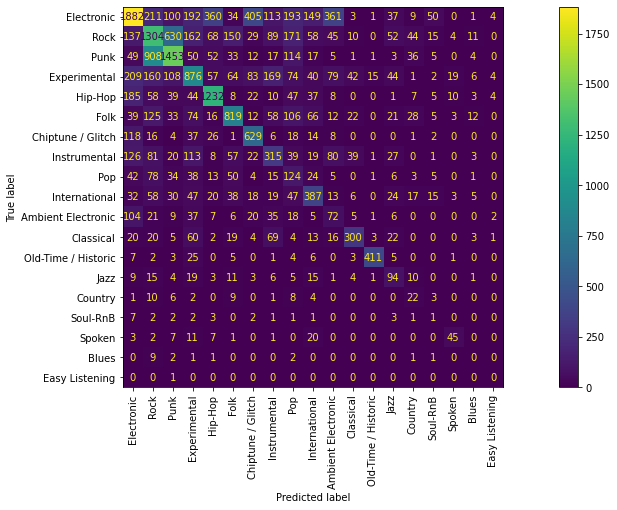

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true=np.argmax(val_preds, axis=1), y_pred=val_gt) #, labels=df_genre.genre.values)
fig, ax = plt.subplots(figsize=(20, 7))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=df_genre.genre)
disp.plot(xticks_rotation="vertical", ax=ax)
plt.show()

In [24]:
print(f"Electronic GT count = {np.sum(cm[0])}")
print(f"Electronic pred count = {np.sum(cm[:, 0])}")

Electronic GT count = 4105
Electronic pred count = 2970


In [25]:
print(f"Electronic FN = {np.sum(cm[0][1:])}")
print(f"Electronic TP = {cm[0][0]}")
print(f"Electronic FP = {np.sum(cm[:, 0][1:])}")

Electronic FN = 2223
Electronic TP = 1882
Electronic FP = 1088


In [26]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

auc_score = roc_auc_score(y_true=val_gt_oh, y_score=val_preds)
auc_score

0.880747057207777

In [27]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
thresh = dict()
roc_auc = dict()
for i in range(Config.NUM_CLASSES):
    fpr[i], tpr[i], thresh[i] = roc_curve(val_gt_oh[:, i], val_preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(val_gt_oh.ravel(), val_preds.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [28]:
optimal_proba_dict = dict()
for i in range(Config.NUM_CLASSES):
  optimal_proba_cutoff = sorted(list(zip(np.abs(tpr[i] - fpr[i]), thresh[i])), key=lambda i: i[0], reverse=True)[0][1]
  optimal_proba_dict[i] = optimal_proba_cutoff
  
optimal_proba_dict

{0: 0.16317691,
 1: 0.13118334,
 2: 0.12256347,
 3: 0.07741776,
 4: 0.07772898,
 5: 0.06252121,
 6: 0.05118654,
 7: 0.038939863,
 8: 0.04485916,
 9: 0.03362385,
 10: 0.020944858,
 11: 0.028756464,
 12: 0.0085573625,
 13: 0.0088827545,
 14: 0.0056789387,
 15: 0.0020869477,
 16: 0.010815488,
 17: 0.0014772059,
 18: 5.4097934e-05}

In [41]:
def get_pred(preds, proba_thresh):
  index_preds = [(index, pred) for index, pred in enumerate(preds)]
  index_preds_sorted = sorted(index_preds, key=lambda item: item[1], reverse=True)
  #print(index_preds_sorted)
  pred_label = 0
  for index, pred in index_preds_sorted:
    if pred > proba_thresh[index]:
      pred_label = index
  return pred_label

In [42]:
from sklearn.metrics import f1_score

def get_overall_f1(average_method=None, optimal_proba=None):  
  if optimal_proba is not None:    
    val_preds_final = [get_pred(pred, optimal_proba) for pred in val_preds]
  else:
    val_preds_final = np.argmax(val_preds, axis=1)  
  # calculate micro f1 on fold 0 val preds before threshold tuning
  val_f1 = f1_score(
      y_true = val_gt, 
      y_pred = val_preds_final, 
      average=average_method
    )
  return val_f1

In [33]:
f1_none = get_overall_f1()
print(f"f1_none = {np.mean(f1_none)}")
f1_none_optimal = get_overall_f1(optimal_proba=list(optimal_proba_dict.values()))
print(f"f1_none_optimal = {np.mean(f1_none_optimal)}")

f1_none = 0.39440610031160767
f1_none_optimal = 0.16856955810391963


In [36]:
optimal_proba = list(optimal_proba_dict.values())
optimal_proba[0] = 0.32
f1_none_optimal = get_overall_f1(optimal_proba=optimal_proba)
print(f"f1_none_optimal = {np.mean(f1_none_optimal)}")

f1_none_optimal = 0.17002106311351128


In [50]:
import optuna

def objective(trial):
    params = {        
        "0": trial.suggest_float("0", 0.1, 0.5,step=0.02),
        "1": trial.suggest_float("1", 0.1, 0.5,step=0.02),
        "2": trial.suggest_float("2", 0.1, 0.5,step=0.02),
        "3": trial.suggest_float("3", 0.1, 0.5,step=0.02),
        "4": trial.suggest_float("4", 0.1, 0.5,step=0.02),
        "5": trial.suggest_float("5", 0.1, 0.5,step=0.02),
        "6": trial.suggest_float("6", 0.1, 0.5,step=0.02),
        "7": trial.suggest_float("7", 0.1, 0.5,step=0.02),
        "8": trial.suggest_float("8", 0.1, 0.5,step=0.02),
        "9": trial.suggest_float("9", 0.1, 0.5,step=0.02),
        "10": trial.suggest_float("10", 0.1, 0.5,step=0.02),
        "11": trial.suggest_float("11", 0.1, 0.5,step=0.02),
        "12": trial.suggest_float("12", 0.1, 0.5,step=0.02),
        "13": trial.suggest_float("13", 0.1, 0.5,step=0.02),
        "14": trial.suggest_float("14", 0.1, 0.5,step=0.02),
        "15": trial.suggest_float("15", 0.1, 0.5,step=0.02),
        "16": trial.suggest_float("16", 0.1, 0.5,step=0.02),
        "17": trial.suggest_float("17", 0.1, 0.5,step=0.02),
        "18": trial.suggest_float("18", 0.1, 0.5,step=0.02),
    }
    optimal_proba = list(optimal_proba_dict.values())
    for key in params.keys():
      optimal_proba[int(key)] = params[key]
    val_f1 = get_overall_f1(average_method="micro", optimal_proba=optimal_proba)    
    trial_num = trial.number    
    return val_f1

study = optuna.create_study(direction="maximize", study_name="ProbaThresholdTuning")    
study.optimize(objective, n_trials=1000)

[I 2022-04-15 07:38:09,546] A new study created in memory with name: ProbaThresholdTuning
[I 2022-04-15 07:38:10,162] Trial 0 finished with value: 0.44610748367654446 and parameters: {'0': 0.28, '1': 0.18, '2': 0.42000000000000004, '3': 0.42000000000000004, '4': 0.18, '5': 0.16, '6': 0.24000000000000002, '7': 0.44000000000000006, '8': 0.45999999999999996, '9': 0.22, '10': 0.16, '11': 0.45999999999999996, '12': 0.44000000000000006, '13': 0.16, '14': 0.4, '15': 0.33999999999999997, '16': 0.24000000000000002, '17': 0.12000000000000001, '18': 0.38}. Best is trial 0 with value: 0.44610748367654446.
[I 2022-04-15 07:38:10,792] Trial 1 finished with value: 0.4453038674033149 and parameters: {'0': 0.45999999999999996, '1': 0.28, '2': 0.14, '3': 0.30000000000000004, '4': 0.33999999999999997, '5': 0.5, '6': 0.45999999999999996, '7': 0.14, '8': 0.38, '9': 0.33999999999999997, '10': 0.26, '11': 0.36, '12': 0.4, '13': 0.16, '14': 0.42000000000000004, '15': 0.38, '16': 0.45999999999999996, '17': 0.4

In [51]:
print(f"Best trial num = {study.best_trial.number} with value = {study.best_value}")
print(f"Best trial params: {study.best_params}")

Best trial num = 912 with value = 0.48744349573078855
Best trial params: {'0': 0.36, '1': 0.30000000000000004, '2': 0.48, '3': 0.24000000000000002, '4': 0.30000000000000004, '5': 0.22, '6': 0.44000000000000006, '7': 0.28, '8': 0.28, '9': 0.26, '10': 0.42000000000000004, '11': 0.26, '12': 0.4, '13': 0.2, '14': 0.33999999999999997, '15': 0.45999999999999996, '16': 0.36, '17': 0.44000000000000006, '18': 0.24000000000000002}


Best trial params: {'0': 0.36, '1': 0.30000000000000004, '2': 0.48, '3': 0.24000000000000002, '4': 0.30000000000000004, '5': 0.22, '6': 0.44000000000000006, '7': 0.28, '8': 0.28, '9': 0.26, '10': 0.42000000000000004, '11': 0.26, '12': 0.4, '13': 0.2, '14': 0.33999999999999997, '15': 0.45999999999999996, '16': 0.36, '17': 0.44000000000000006, '18': 0.24000000000000002}

In [50]:
# micro average calculate f1 for all classes and entire dataset in one go. 
f1_micro = get_overall_f1("micro")
print(f"f1_micro = {f1_micro}")
f1_micro_optimal = get_overall_f1("micro", True)
print(f"f1_micro_optimal = {f1_micro_optimal}")

f1_micro = 0.5005524861878453
f1_micro_optimal = 0.14580612757408337


In [52]:
# macro average calculate f1 per class and then averages it
f1_macro = get_overall_f1("macro")
print(f"f1_macro = {f1_macro}")
f1_macro_optimal = get_overall_f1("macro", True)
print(f"f1_macro_optimal = {f1_macro_optimal}")

f1_macro = 0.39440610031160767
f1_macro_optimal = 0.16856955810391963


In [33]:
# f1 score for a specific class
def get_class_f1(val_gt, val_preds, label_id, proba_threshold=0.5):
  val_preds_class = val_preds[:, label_id]
  val_gt_class = val_gt_oh[:, label_id]  
  val_preds_class_final = [1 if i >= proba_threshold else 0 for i in val_preds_class]
  val_f1_class = f1_score(
      y_true = val_gt_class,
      y_pred = val_preds_class,
      average = "binary"
  )
  return val_f1_class

In [34]:
class_f1_dict_before = dict()
for i in range(Config.NUM_CLASSES):
  class_f1_dict_before[i] = get_class_f1(val_gt, val_preds, label_id=i)

pd.Series(class_f1_dict_before).values.mean()

ValueError: ignored

In [ ]:
class_f1_dict_before

In [ ]:
class_f1_dict = dict()
for i in range(Config.NUM_CLASSES):
  class_f1_dict[i] = get_class_f1(val_gt, val_preds, label_id=i, proba_threshold=optimal_proba_dict[i])

class_f1_dict  

In [ ]:
pd.Series(class_f1_dict).values.mean()

In [ ]:
plt.figure(figsize=(15, 8))
lw = 2
for i in range(Config.NUM_CLASSES):
    plt.plot(
        fpr[i],
        tpr[i],        
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )
# Plot micro avg ROC curve
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()